[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
# packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  mean_mat = np.mean(x_train, axis=0)
  
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  
  #finally, flattening the data
  x_train = np.reshape(x_train_centered, (60000,784))
  x_test = np.reshape(x_test_centered, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train[:10000], y_train[:10000], x_test, y_test
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

4431872/4422102 [==============================] - 0s 0us/step


# Model Implementation - SoftMax


**Activation functions**

In [ ]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Accuracy function

In [ ]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

## Model - ReLu

In [ ]:
class MLPRelu:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = relu(q2)          
            yh = softmax2D(np.dot(z2, w))#N
            train_acc = evaluate_acc(yh, y)
            ## Backpropagation          
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  

            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x

            dparams = [dv1, dv2, dw]
            return dparams, train_acc
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, batch_train_accs = optimizer.run_mini_batch(gradient, x, y, params0) 
        return self, batch_train_accs
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [ ]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    mini_batches.append( ( x_batch, y_batch ) )
  return mini_batches

# Gradient Descent 

---



In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=800, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        print(t)
        return params
    
    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        batch_train_acc, chunk = [], []
        norms = np.array([np.inf])
        t=1
        mini_batches = mini_batcher(x, y, batch_size)
        print("#mini batches",len(mini_batches))
        batch_index=0
        while np.any(norms > self.epsilon) and t < self.max_iters * len(mini_batches):
            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            if(batch_index == batch_size):
              mini_batches = mini_batcher(x, y, batch_size)
              batch_index = 0
            batch_index +=1
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            chunk.append(temp_acc)
            if t % 10000 == 0:
              print(f"Epoch{t}:{temp_acc}%")
            t += 1
            if t%len(mini_batches) == 0:
              batch_train_acc.append(np.mean(chunk))
              chunk = []
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, batch_train_acc

# MNIST DataSet

In [ ]:
model1 = MLPRelu(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32)
y_pred1, batch_train_accs = model1.fit(x_train, y_train, optimizer)

#mini batches 313
Epoch10000:65.625%
Epoch20000:93.75%
Epoch30000:87.5%
Epoch40000:87.5%
Epoch50000:81.25%
Epoch60000:87.5%
Epoch70000:90.625%
Epoch80000:93.75%
Epoch90000:93.75%
Epoch100000:96.875%
Epoch110000:96.875%
Epoch120000:96.875%
Epoch130000:96.875%
Epoch140000:96.875%
Epoch150000:100.0%
Epoch160000:100.0%
Epoch170000:100.0%
Epoch180000:96.875%
Epoch190000:100.0%
Epoch200000:100.0%
Epoch210000:100.0%
Epoch220000:100.0%
Epoch230000:100.0%
Epoch240000:100.0%
Epoch250000:100.0%


In [ ]:
print("Number of full training batch iterations:",len(batch_train_accs))
print("Accuracies per training batch:")
for i in batch_train_accs:
  print(i)
y_test_pred1 = model1.predict(x_test)
print("--------")
print("final accuracy")
print(evaluate_acc(y_test_pred1, y_test))

Number of full training batch iterations: 800
Accuracies per training batch:
32.39182692307692
55.91054313099041
62.41014376996805
65.0758785942492
66.97284345047923
68.370607028754
69.75838658146965
70.65694888178913
71.48562300319489
72.00479233226837
72.75359424920129
73.1729233226837
73.72204472843451
74.33107028753993
74.78035143769968
75.25958466453675
75.66892971246007
75.88857827476038
76.24800319488818
76.50758785942492
76.6673322683706
77.0167731629393
77.2064696485623
77.50599041533546
77.67571884984025
77.77555910543131
78.05511182108626
78.19488817891374
78.52436102236422
78.77396166134186
79.0435303514377
79.20327476038338
79.40295527156549
79.50279552715655
79.69249201277955
79.7623801916933
79.90215654952077
79.9820287539936
80.05191693290735
80.10183706070288
80.18170926517571
80.35143769968052
80.55111821086263
80.71086261980831
80.85063897763578
80.86062300319489
81.00039936102236
81.21006389776358
81.25
81.33985623003196
81.4297124600639
81.53953674121406
81.5994408

No handles with labels found to put in legend.


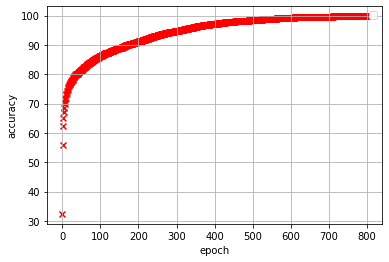

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(batch_train_accs)), batch_train_accs, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
print(evaluate_acc(y_test_pred1, y_test))

77.81
